In [1]:
import pandas as pd
import numpy as np
import collections
import ast
import time
from tqdm import tqdm
import csv

# Odczyt rozkładu z jednej iteracji 

In [2]:
#distribution_df = pd.read_csv('../distributions_primary.csv')
distribution_df = pd.read_csv('../distributions_primary_full.csv')

distribution_df.reset_index(drop=True, inplace=True)
distribution_df.drop(columns=distribution_df.columns[0], axis=1, inplace=True)
display(distribution_df.head())

,settings,distribution
0,"{'N': 100, 'k': 25, 'pn': [0.0, 0.0, 0.0, 1.0]}","{378886: 151, 164289: 119, 219194: 280, 285797..."


In [3]:
def string_to_counter(distribution_str):
    distribution_dict = ast.literal_eval(distribution_str)
    return collections.Counter(distribution_dict)

tqdm.pandas()
distribution_df['distribution'] = distribution_df['distribution'].progress_apply(string_to_counter)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


In [4]:
def create_citation_distribution(counter):
    # Zliczanie, ile razy każda liczba cytacji występuje (ilosc cytowań, ile prac było tyle razy zacytowanych)
    citation_counts = collections.Counter(counter.values())
    return citation_counts

distribution_df['distribution_citations'] = distribution_df['distribution'].apply(create_citation_distribution)

In [5]:
display(distribution_df)

,settings,distribution,distribution_citations
0,"{'N': 100, 'k': 25, 'pn': [0.0, 0.0, 0.0, 1.0]}","{378886: 151, 164289: 119, 219194: 280, 285797...","{151: 147, 119: 275, 280: 56, 13: 4181, 39: 10..."


# Sprawdzenie powerlaw

In [6]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import powerlaw
import ast
from scipy.stats import ks_2samp

In [7]:
distribution_citations = distribution_df.iloc[0].distribution_citations

In [8]:
display(distribution_citations)

Counter({1: 66117,
         2: 33132,
         3: 21832,
         4: 16129,
         5: 12307,
         6: 10216,
         7: 8550,
         8: 7269,
         9: 6368,
         10: 5733,
         11: 5145,
         12: 4667,
         13: 4181,
         14: 3971,
         15: 3520,
         16: 3208,
         17: 3051,
         18: 2866,
         19: 2698,
         20: 2573,
         21: 2365,
         22: 2256,
         23: 2144,
         24: 2066,
         25: 1908,
         26: 1859,
         27: 1704,
         28: 1665,
         31: 1535,
         29: 1532,
         30: 1473,
         32: 1394,
         33: 1350,
         34: 1274,
         35: 1264,
         38: 1198,
         36: 1171,
         37: 1157,
         39: 1080,
         42: 1022,
         41: 1015,
         40: 1013,
         43: 984,
         45: 956,
         44: 925,
         46: 893,
         48: 859,
         47: 844,
         49: 844,
         51: 815,
         50: 801,
         52: 743,
         55: 735,
       

In [14]:
src = dict(distribution_citations)
sorted_keys = sorted(distribution_citations.keys())
sorted_values = [src[key] for key in sorted_keys]

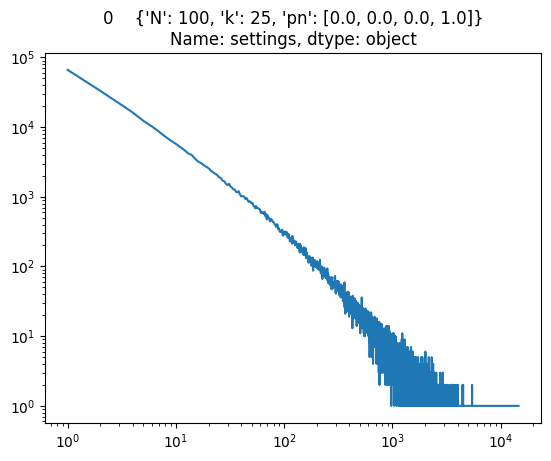

In [15]:
plt.title(distribution_df.settings)
plt.loglog(sorted_keys, sorted_values)
plt.show()

In [30]:
fit = powerlaw.Fit(sorted_values)
alpha = fit.alpha
print(f"Wartość współczynnika charakterystycznego: {alpha}")

Calculating best minimal value for power law fit
Wartość współczynnika charakterystycznego: 1.4559422373783706


<Axes: >

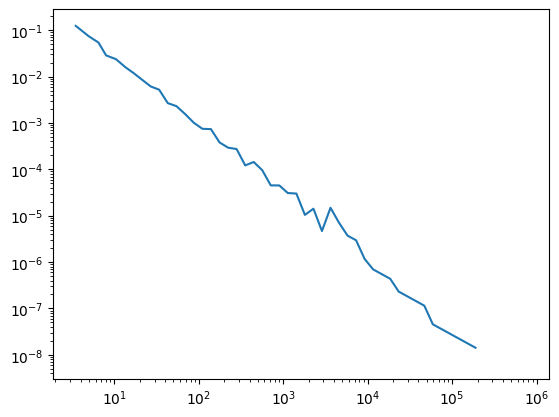

In [31]:
fit.plot_pdf() # gęstość rozkładu

<Axes: >

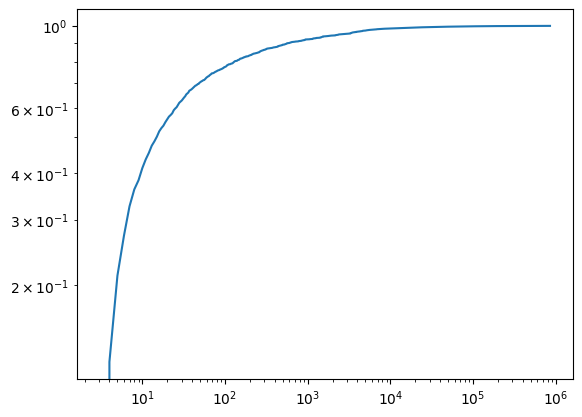

In [32]:
fit.plot_cdf() # kumulatywna gęstość rozkładu

In [19]:
fit.distribution_compare('power_law', 'exponential')

(36.206385819679596, 0.0071016615060008415)

## Wnioski
Rozkład wygenerowany na skutek szukania tylko po podobieństwie z wyłączeniem paginacji oraz wag parametrów jest rozkładem potęgowym

In [34]:
distribution_df['sorted_keys'] = distribution_df.distribution_citations.apply(lambda x: sorted(x.keys()))
distribution_df['sorted_values'] = distribution_df[["sorted_keys", "distribution_citations"]].apply(lambda x: [x[1][y] for y in x[0]], axis=1)
distribution_df['powerlaw_fit'] = distribution_df.sorted_values.apply(lambda x: powerlaw.Fit(x))
distribution_df['powerlaw_pval'] = distribution_df.powerlaw_fit.apply(lambda x: x.distribution_compare('power_law', 'exponential')[1])
distribution_df['powerlaw_alpha'] = distribution_df.powerlaw_fit.apply(lambda x: x.alpha)

Calculating best minimal value for power law fit


C:\Users\user\AppData\Local\Temp\ipykernel_1976\2605229278.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distribution_df['sorted_values'] = distribution_df[["sorted_keys", "distribution_citations"]].apply(lambda x: [x[1][y] for y in x[0]], axis=1)


In [35]:
distribution_df.powerlaw_pval.describe()

count    1.000000
mean     0.007102
std           NaN
min      0.007102
25%      0.007102
50%      0.007102
75%      0.007102
max      0.007102
Name: powerlaw_pval, dtype: float64

In [36]:
distribution_df.ks_test.describe()

AttributeError: 'DataFrame' object has no attribute 'ks_test'

# Results

In [37]:
dblp_distribution_df = pd.read_csv('dblp_distribution_citations.csv')
src_dist = dblp_distribution_df.iloc[0,0]
src = ast.literal_eval(src_dist)

sorted_keys = sorted(src.keys())
sorted_values = [src[key] for key in tqdm(sorted_keys, desc="Processing keys")]

Processing keys: 100%|█████████████████████████████████████████████████████████████████████| 3217/3217 [00:00<?, ?it/s]


In [38]:
fit = powerlaw.Fit(sorted_values)

Calculating best minimal value for power law fit


In [39]:
fit_exp = distribution_df.powerlaw_fit.iloc[0]

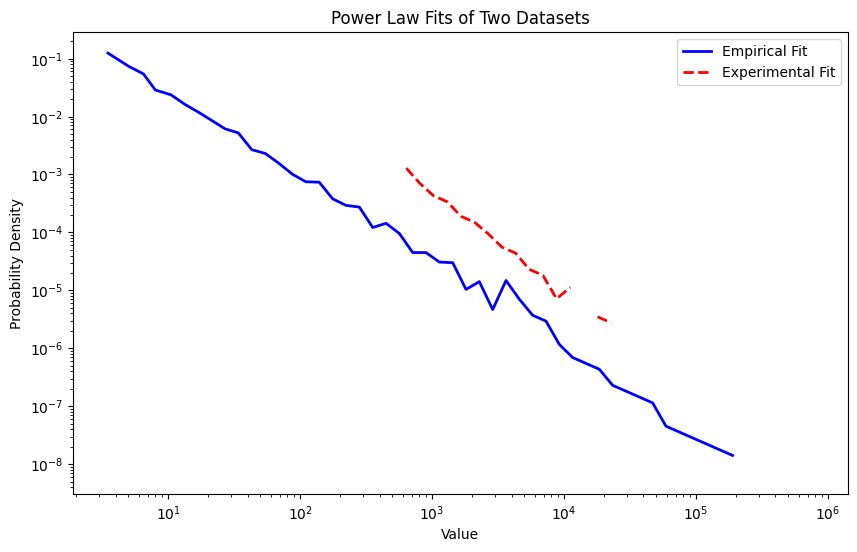

In [ ]:
plt.figure(figsize=(10, 6))

fit.plot_pdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2)
fit_exp.plot_pdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2)

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Power Law Fits of Two Datasets')
plt.legend()
plt.savefig(f'../reports/figures/pdf_plot_no_rank.png', bbox_inches='tight')


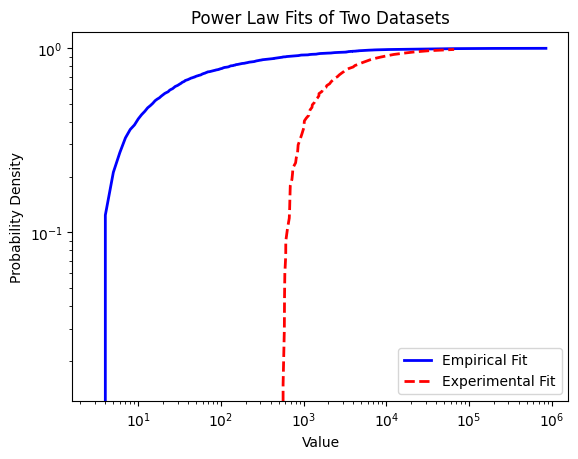

In [ ]:
fit.plot_cdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2)
fit_exp.plot_cdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2)

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Power Law Fits of Two Datasets')
plt.legend()
plt.savefig(f'../reports/figures/cdf_plot_no_rank.png', bbox_inches='tight')


In [ ]:
def pdf_cdf_plot(fit_exp, fit, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Tworzy dwa wykresy obok siebie

    # Wykres PDF
    fit.plot_pdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2, ax=axs[0])
    fit_exp.plot_pdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2, ax=axs[0])
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Probability Density')
    axs[0].set_title(f'PDF Comparison')
    axs[0].legend()

    # Wykres CDF
    fit.plot_cdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2, ax=axs[1])
    fit_exp.plot_cdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2, ax=axs[1])
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Cumulative Probability')
    axs[1].set_title(f'CDF Comparison')
    axs[1].legend()

    plt.tight_layout()  # Automatycznie dostosowuje rozmieszczenie
    plt.savefig(f'../reports/figures/pdf_cdf_plot_no_rank.png', bbox_inches='tight')


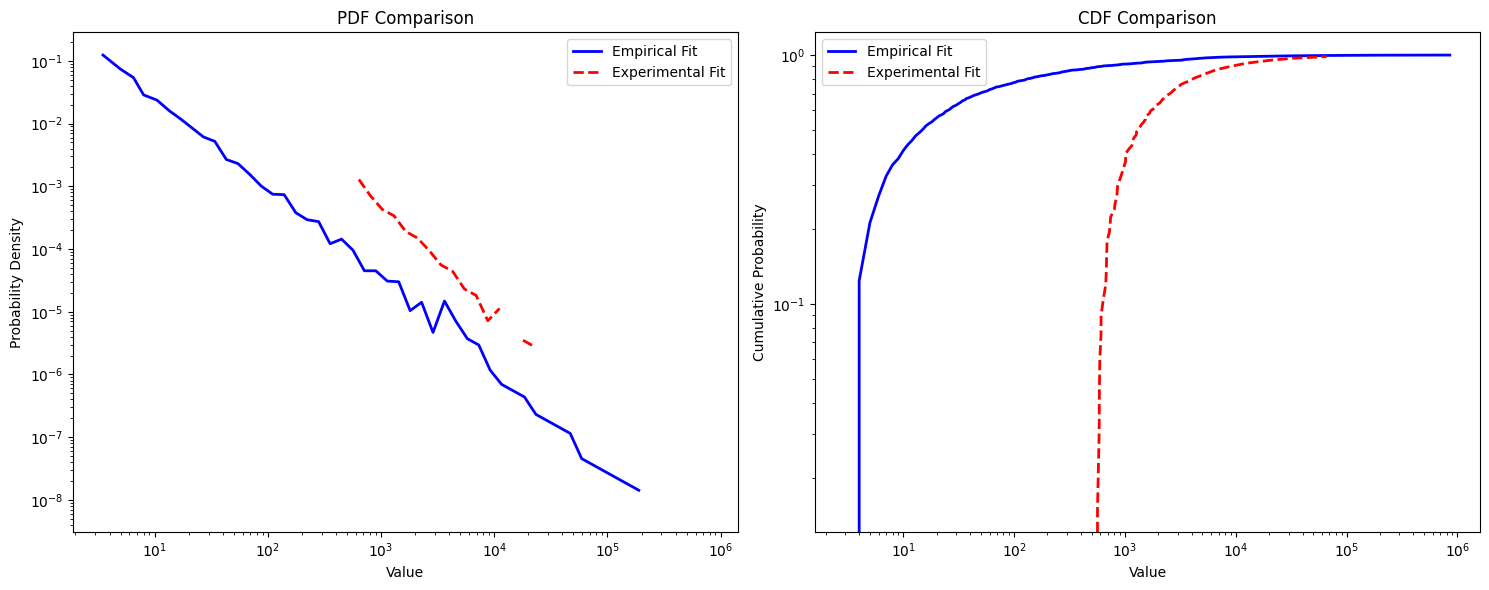

In [47]:
pdf_cdf_plot(fit_exp, fit, "No rank")